Final Project

This project is structured to encompass various stages, starting with exploratory data analysis (EDA) to gain deep insights into the data. We will preprocess the data, engineer relevant features, and select appropriate machine learning algorithms for binary classification tasks. Importantly, we will adhere to the guidelines of not using labeled data for training, treating it as our subject matter expert’s input.

In [65]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

class SME():

    def __init__(self):
        self.asked = 0
        self.df = self.get()

    def get(self):
        X_train = pd.read_csv('https://raw.githubusercontent.com/msaricaumbc/DS_data/master/ds602/final3/X_train.csv')
        y_train = pd.read_csv('https://raw.githubusercontent.com/msaricaumbc/DS_data/master/ds602/final3/y_train.csv')

        X_train['Left'] = y_train
        return X_train

    def ask(self, gender, distance, years_worked, hire_date, prev_salary, current_salary, dep_code):
        self.asked += 1
        #  print(self.asked)

        if self.asked > 500:
            raise Exception("Sorry, you have asked enough")

        result = self.df.query(f"Gender=={gender} and Distance=='{distance}' and YearsWorked == {years_worked} and HireDate == '{hire_date}' and PreviousSalary == '{prev_salary}' and Salary == '{current_salary}' and DepartmentCode == {dep_code}")

        return result['Left'][0]

In [66]:
sme= SME()

In [67]:
df = sme.get()

In [68]:
df.head()

,Gender,Distance,YearsWorked,HireDate,PreviousSalary,Salary,DepartmentCode,Left
0,0,~20miles,8,2007-09-05,63K,66K,3,1
1,0,>30miles,7,2011-10-16,60K,63K,3,1
2,0,~15miles,7,2011-05-18,59K,60K,3,0
3,1,<5mile,3,2000-06-30,60K,61K,2,0
4,1,~10miles,9,2010-04-28,56K,57K,7,0


In [69]:
df.Distance.nunique()

5

**Objective**: Develop a model to predict employee attrition using past data, augmented with labeled testing data provided by John.
Data Exploration: Understand feature distributions, identify missing values, outliers, and feature-target relationships.
Model Development: Consider various algorithms for binary classification, using evaluation metrics like accuracy, precision, recall, and F1-score.

Data handling

In [70]:
df.columns

Index(['Gender', 'Distance', 'YearsWorked', 'HireDate', 'PreviousSalary',
       'Salary', 'DepartmentCode', 'Left'],
      dtype='object')

In [71]:
df.nunique()

Gender               2
Distance             5
YearsWorked         14
HireDate          4458
PreviousSalary      22
Salary              25
DepartmentCode       6
Left                 2
dtype: int64

In [72]:
df.isnull().sum()

Gender             0
Distance          10
YearsWorked        0
HireDate           0
PreviousSalary     0
Salary             0
DepartmentCode     0
Left               0
dtype: int64

In [73]:
X_train = pd.read_csv('https://raw.githubusercontent.com/msaricaumbc/DS_data/master/ds602/final3/X_train.csv')
X_test = pd.read_csv('https://raw.githubusercontent.com/msaricaumbc/DS_data/master/ds602/final3/X_test.csv')
y_test = pd.read_csv('https://raw.githubusercontent.com/msaricaumbc/DS_data/master/ds602/final3/y_test.csv')
y_train = pd.read_csv('predicted_labels.csv') # generated using random forest , refer to other notebook provided 

In [75]:
X_train

,Gender,Distance,YearsWorked,HireDate,PreviousSalary,Salary,DepartmentCode
0,0,~20miles,8,2007-09-05,63K,66K,3
1,0,>30miles,7,2011-10-16,60K,63K,3
2,0,~15miles,7,2011-05-18,59K,60K,3
3,1,<5mile,3,2000-06-30,60K,61K,2
4,1,~10miles,9,2010-04-28,56K,57K,7
...,...,...,...,...,...,...,...
7495,0,>30miles,5,2014-03-15,60K,62K,6
7496,0,~10miles,7,2011-07-10,64K,68K,3
7497,0,~10miles,8,2006-08-19,56K,57K,2
7498,0,~20miles,6,2016-09-18,60K,62K,5


In [76]:
X_train.isnull().sum()

Gender             0
Distance          10
YearsWorked        0
HireDate           0
PreviousSalary     0
Salary             0
DepartmentCode     0
dtype: int64

In [77]:
X_train.nunique()

Gender               2
Distance             5
YearsWorked         14
HireDate          4458
PreviousSalary      22
Salary              25
DepartmentCode       6
dtype: int64

In [78]:
X_train.PreviousSalary.value_counts()

PreviousSalary
60K    983
59K    954
61K    920
58K    811
62K    747
57K    633
63K    573
56K    455
64K    350
55K    327
54K    203
65K    188
53K    122
66K     96
52K     53
51K     28
67K     25
50K     15
68K      8
49K      5
48K      3
69K      1
Name: count, dtype: int64

In [79]:
def convert_salary(df, columns):
    for col in columns:
        df[col] = df[col].apply(lambda x: float(x.replace('K', '')) * 1000 if 'K' in x else float(x))
    return df

columns_to_convert = ['PreviousSalary', 'Salary']
X_train = convert_salary(X_train, columns_to_convert)
X_test = convert_salary(X_test, columns_to_convert)

In [80]:
X_train

,Gender,Distance,YearsWorked,HireDate,PreviousSalary,Salary,DepartmentCode
0,0,~20miles,8,2007-09-05,63000.0,66000.0,3
1,0,>30miles,7,2011-10-16,60000.0,63000.0,3
2,0,~15miles,7,2011-05-18,59000.0,60000.0,3
3,1,<5mile,3,2000-06-30,60000.0,61000.0,2
4,1,~10miles,9,2010-04-28,56000.0,57000.0,7
...,...,...,...,...,...,...,...
7495,0,>30miles,5,2014-03-15,60000.0,62000.0,6
7496,0,~10miles,7,2011-07-10,64000.0,68000.0,3
7497,0,~10miles,8,2006-08-19,56000.0,57000.0,2
7498,0,~20miles,6,2016-09-18,60000.0,62000.0,5


In [81]:
X_train = X_train.drop('HireDate',axis=1)

In [82]:
X_test = X_test.drop('HireDate',axis=1)

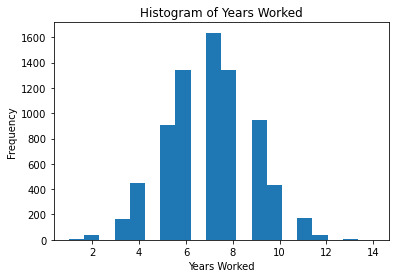

In [83]:
plt.hist(df['YearsWorked'], bins=20)
plt.xlabel('Years Worked')
plt.ylabel('Frequency')
plt.title('Histogram of Years Worked')
plt.show()

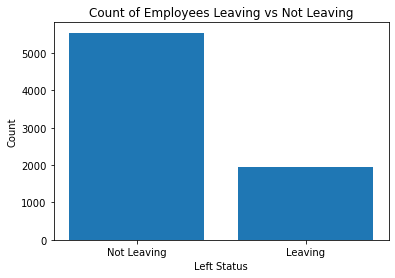

In [84]:
import pandas as pd
import matplotlib.pyplot as plt


left_counts = df['Left'].value_counts()

# Create a bar graph
plt.bar(left_counts.index, left_counts.values)

# Customize the plot
plt.xlabel('Left Status')
plt.ylabel('Count')
plt.title('Count of Employees Leaving vs Not Leaving')
plt.xticks([0, 1], ['Not Leaving', 'Leaving'])

# Show the plot
plt.show()

Column handling

In [85]:
X_train

,Gender,Distance,YearsWorked,PreviousSalary,Salary,DepartmentCode
0,0,~20miles,8,63000.0,66000.0,3
1,0,>30miles,7,60000.0,63000.0,3
2,0,~15miles,7,59000.0,60000.0,3
3,1,<5mile,3,60000.0,61000.0,2
4,1,~10miles,9,56000.0,57000.0,7
...,...,...,...,...,...,...
7495,0,>30miles,5,60000.0,62000.0,6
7496,0,~10miles,7,64000.0,68000.0,3
7497,0,~10miles,8,56000.0,57000.0,2
7498,0,~20miles,6,60000.0,62000.0,5


In [86]:
from sklearn.impute import SimpleImputer
import pandas as pd


numerical_cols = ['YearsWorked', 'PreviousSalary', 'Salary']
categorical_cols = ['Gender', 'Distance', 'DepartmentCode']


numerical_imputer = SimpleImputer(strategy='median')
X_train[numerical_cols] = numerical_imputer.fit_transform(X_train[numerical_cols])

X_train_org = X_train.copy()


categorical_imputer = SimpleImputer(strategy='most_frequent')
X_train[categorical_cols] = categorical_imputer.fit_transform(X_train[categorical_cols])

In [87]:
#One hot encoding
import pandas as pd

categorical_cols = ['Gender', 'Distance', 'DepartmentCode']
X_train_encoded = pd.get_dummies(X_train, columns=categorical_cols)
print(X_train_encoded.head())

   YearsWorked  PreviousSalary   Salary  Gender_0  Gender_1  Distance_<5mile  \
0          8.0         63000.0  66000.0      True     False            False   
1          7.0         60000.0  63000.0      True     False            False   
2          7.0         59000.0  60000.0      True     False            False   
3          3.0         60000.0  61000.0     False      True             True   
4          9.0         56000.0  57000.0     False      True            False   

   Distance_>30miles  Distance_~10miles  Distance_~15miles  Distance_~20miles  \
0              False              False              False               True   
1               True              False              False              False   
2              False              False               True              False   
3              False              False              False              False   
4              False               True              False              False   

   DepartmentCode_1  DepartmentC

In [88]:
X_test_encoded = pd.get_dummies(X_test, columns=categorical_cols)

In [90]:
X_train_final = X_train_encoded
y_train_final = y_train

In [91]:
y_train_final

,Predicted_Label
0,0.89
1,1.00
2,0.00
3,0.12
4,0.05
...,...
7495,0.88
7496,0.00
7497,0.05
7498,0.98


In [92]:
y_train_final = y_train_final['Predicted_Label'].apply(lambda x: 1 if x >= 0.5 else 0)

In [93]:
y_train_final

0       1
1       1
2       0
3       0
4       0
       ..
7495    1
7496    0
7497    0
7498    1
7499    1
Name: Predicted_Label, Length: 7500, dtype: int64

In [61]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score


classifiers = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(),
    'Support Vector Machine': SVC()
}

param_grids = {
    'Logistic Regression': {'C': [0.1, 1, 10]},
    'Random Forest': {'n_estimators': [50, 100, 150], 'max_depth': [None, 5, 10]},
    'Support Vector Machine': {'C': [0.1, 1, 10], 'gamma': [0.1, 1, 10]}
}

# Perform Grid Search CV for each classifier
results = {}
for clf_name, clf in classifiers.items():
    grid_search = GridSearchCV(clf, param_grids[clf_name], cv=5, scoring='accuracy')
    grid_search.fit(X_train_final, y_train_final)
    best_params = grid_search.best_params_
    best_clf = grid_search.best_estimator_
    y_pred = best_clf.predict(X_test_encoded)
    accuracy = accuracy_score(y_test, y_pred)
    results[clf_name] = {'Best Params': best_params, 'Accuracy on Test Data': accuracy}

# Print the results in a table format
print("Algorithm\t\tBest Params\t\tAccuracy on Test Data")
print("------------------------------------------------------------")
for clf_name, result in results.items():
    print(f"{clf_name}\t{result['Best Params']}\t\t{result['Accuracy on Test Data']:.4f}")

Algorithm		Best Params		Accuracy on Test Data
------------------------------------------------------------
Logistic Regression	{'C': 1}		0.9132
Random Forest	{'max_depth': None, 'n_estimators': 150}		0.9056
Support Vector Machine	{'C': 10, 'gamma': 0.1}		0.9008


In [94]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Define the Logistic Regression classifier and its updated parameter grid for Grid Search CV
logreg_classifier = LogisticRegression(max_iter=1000)

param_grid_logreg = {
    'C': [0.01,0.005,0.1, 1, 5.5, 10, 30, 90],
}

# Perform Grid Search CV for Logistic Regression
grid_search_logreg = GridSearchCV(logreg_classifier, param_grid_logreg, cv=5, scoring='accuracy')
grid_search_logreg.fit(X_train_final, y_train_final)
best_params_logreg = grid_search_logreg.best_params_
best_logreg = grid_search_logreg.best_estimator_
y_pred_logreg = best_logreg.predict(X_test_encoded)
accuracy_logreg = accuracy_score(y_test, y_pred_logreg)

# Print the results for Logistic Regression
print("Logistic Regression:")
print("Best Params:", best_params_logreg)
print("Accuracy on Test Data:", accuracy_logreg)

Logistic Regression:
Best Params: {'C': 1}
Accuracy on Test Data: 0.9132


In [95]:
from sklearn.metrics import classification_report

# Calculate the classification report for Logistic Regression
classification_report_logreg = classification_report(y_test, y_pred_logreg)

# Print the classification report
print("Classification Report for Logistic Regression:")
print(classification_report_logreg)

Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.95      0.93      0.94      1847
           1       0.81      0.88      0.84       653

    accuracy                           0.91      2500
   macro avg       0.88      0.90      0.89      2500
weighted avg       0.92      0.91      0.91      2500



**conclusion:**
The Logistic Regression model outperformed the Random Forest and Support Vector Machine models in terms of accuracy on the test data.
•    However, all three models struggled to accurately predict instances of employees who left (‘left’ class), as indicated by low precision, recall, and F1-score for that class.